# Read Gaia & Compute average statistics - not ease!!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn, unique
import warnings
from astropy.utils.exceptions import AstropyWarning
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
import getpass, sys
user = getpass.getuser()
sys.path.append('/Users/' + user + '/Dropbox/my_python_packages')
from gaia.Basic import Basic
from itertools import combinations

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## see https://www.cosmos.esa.int/web/gaia/dr2-known-issues

In [2]:
# Read Control Sample ========================
warnings.simplefilter('ignore', category=AstropyWarning)
control = Table.read('OPH___control_sample.vot', format = 'votable')
control['cat_id_2'] = [inp for inp in range(len(control))]
control

cat_id,ra,dec,source_id,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_flux_over_error,phot_rp_mean_mag,radial_velocity,radial_velocity_error,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,a_g_percentile_upper_2,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_chi2_al,astrometric_n_good_obs_al,visibility_periods_used,phot_bp_rp_excess_factor,bp_rp,separison,__BP-RP___2,unit_weight_e,u_max,ruwe,cat_id_2
,deg,deg,,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,mag,,,mag,,mag,km.s**-1,km.s**-1,K,K,K,mag,mag,mag,mag,mas,,,,,,mag,,mag,,mag,,
int64,float64,float64,int64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int32,int16,float32,float32,float64,float32,float64,float32,float64,int64
2,245.3269737027558,-22.91620399349404,6050297206990387840,7.19559580892301,0.07682664231892795,93.660164,-8.324771290633084,0.18914042903077904,-24.075212883984065,0.14228709548920793,15.157623,220.97343,53.485527,17.166464,69.35991,13.804977,--,--,4189.2227,3676.2734,4461.633,--,--,--,--,0.4191824175152108,25.449599729686287,1069.6145,275,11,1.5960032,3.3614864,0.0001334724966612804,11.299591,1.9903605684445675,2.8599296,1.0274796198108476,0
3,245.32990984403395,-23.708088553879573,6050172068822858624,7.173897288330354,0.060638388378559546,118.3062,-11.256267093236755,0.13042875990466452,-24.44949078876399,0.08116230893448978,6.9739947,3562.241,942.29254,7.089657,692.05695,6.794271,--,--,7840.0,7611.5,8140.0,0.659,0.416,0.9665,0.9665,0.07392759642916422,2.2635520472322264,951.90125,292,12,1.1617917,0.29538584,0.00011427956678144378,0.087252796,1.8211889185538581,14.695226,0.9821955313142032,1
4,245.38301878662597,-23.027980445729803,6050277999896626944,7.299055955109673,0.11451174287882926,63.740677,-6.6259766475041575,0.31447022330457425,-26.258460277951627,0.22263162341534146,16.555536,30.680552,10.347965,18.379335,10.629223,15.074344,--,--,3891.2,3488.03,4328.0405,--,--,--,--,0.5862693223930294,19.600140503223855,843.14636,289,11,1.8035346,3.3049917,0.00011782232752329993,10.92297,1.723027921823295,2.1623905,1.2411179545895732,2
8,245.45198441638425,-23.67436581269194,6050177459004435072,6.6315638396440715,0.3617811996455125,18.330317,-5.388832897176572,0.6857601022850729,-26.45882679854636,0.4365224116387288,18.53504,455.83908,9.795485,20.693605,131.1527,16.892328,--,--,--,--,--,--,--,--,--,1.0066483656890928,5.144683139374342,465.0384,287,11,2.034631,3.8012772,0.00011825064422183025,14.449708,1.2841621038297093,1.4554478,1.0521658474598887,3
10,245.57718591932178,-23.36348590759914,6050218523189626624,6.973628493122273,0.04646854979821978,150.072,-6.934294262022265,0.11279730033201309,-26.278467476332743,0.07912045523909245,12.235949,172.3374,44.62965,13.249967,60.97188,11.220009,-8.284734747727441,5.290414255954069,3766.7598,3661.0,4191.995,--,--,--,--,0.0,0.0,828.3583,283,11,1.3740582,2.0299578,0.00012604180620913756,4.1207285,1.7261825019672157,5.1301346,1.3013502169068802,4
13,245.6039793587639,-23.498708137344643,6050204641855013376,7.229316851779956,0.09016528783365696,80.17849,-8.10744943037449,0.19502052030138411,-25.82996570231135,0.12446352803548832,15.002239,191.57916,44.68094,16.859365,162.89136,13.614469,--,--,4063.9873,3562.7249,4785.9526,1.2923,0.8384,1.6263,1.6263,0.4243569855911563,26.495058960737346,918.8624,270,12,1.6619745,3.244897,6.47831887513359e-05,10.529356,1.8620970393595886,2.9502022,1.0182359949865092,5
17,245.68725230143127,-23.287106821088578,6050220683555127680,6.892473734833258,0.21403161013681746,32.203064,-8.662657180700226,0.49059220343009413,-25.42148397617668,0.3284801901778264,18.115103,554.606,10.645539,20.656038,137.80865,16.537401,--,--,--,--

In [3]:
def get_ksigma(tb_inp, showplot = True):
# Examine brightness distribution to discenr criteria =====
    if showplot:
        plt.figure(figsize=[10,5])
        plt.xlabel('G band magnitude', fontsize = 18)
        hists = plt.hist(control['phot_g_mean_mag'], bins=15)
        plt.vlines(x=13, ymin=0, ymax=hists[0].max(), linestyles='--')
        plt.show()

    bright = control[control['phot_g_mean_mag'] <13. ]
    faint  = control[control['phot_g_mean_mag'] >13. ]

    r_bright = np.round(len(bright) /len(control)*100,1)
    r_faint  = np.round(len(faint)  /len(control)*100,1)

    print(r_faint,  '% of faint  (G>13) stars')
    print(r_bright, '% of bright (G<13) stars')
                        
    if r_faint >50: out = {'k':1.08, 'sigma':0.043, 'regime':'faint'}
    if r_faint <50: out = {'k':1.08, 'sigma':0.021, 'regime':'bright'}
    return out

def get_coords(tb_inp, tb_index, frame = 'icrs'): # try 'fk5'
    source = tb_inp[tb_index]
    ra     = source['ra']
    dec    = source['dec']
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame=frame)
    return {'ra':ra, 'dec':dec, 'coords':coords}


def get_pair_coords(tb_inp, tb_indexex_tupple):
    coords_1 = get_coords(tb_inp, tb_indexex_tupple[0])
    coords_2 = get_coords(tb_inp, tb_indexex_tupple[1])
    return coords_1['coords'].separation(coords_2['coords']).degree


def get_gaia_variance(theta):
    diff         = np.abs(var_gaia_dr2['theta'] - theta)
    diff_v       = np.where(diff == np.min(diff))[0][0]

    V_plx_out = var_gaia_dr2[diff_v]['V_plx']
    V_mu__out = var_gaia_dr2[diff_v]['V_mu']
    return {'theta':theta, 'V_plx': V_plx_out, 'V_mu':V_mu__out}

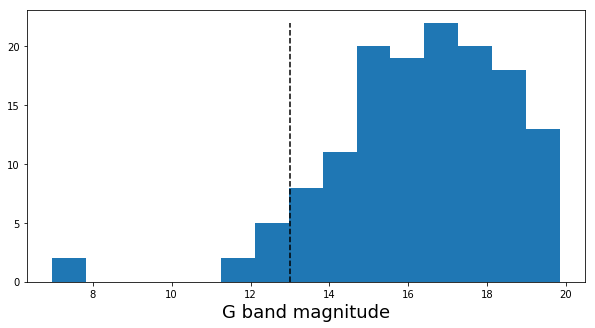

92.1 % of faint  (G>13) stars
7.9 % of bright (G<13) stars


{'k': 1.08, 'regime': 'faint', 'sigma': 0.043}

In [4]:
ksigma = get_ksigma(control)
ksigma

In [8]:
# Read Covarianza table ==================
var_gaia_dr2 = Table.read('/Users/hcanovas/Astrofisica/Gaia/DR2_spatialCov_V1/spatialCovarianceQso.txt', format = 'ascii')
var_gaia_dr2['theta'].unit = u.degree
var_gaia_dr2['V_plx'].unit = u.microarcsecond**2
var_gaia_dr2['V_mu'].unit  = u.microarcsecond**2 / u.year**2
var_gaia_dr2[0:15]

theta,V_plx,V_mu
deg,uarcsec2,uarcsec2 / yr2
float64,float64,float64
0.0625,1811.7195276918228,4485.088207521745
0.1875,1348.5490130512085,1771.3020997829863
0.3125,202.78241614792717,887.7447800112914
0.4375,155.20661230697124,39.338103082495316
0.5625,278.19273682898034,1301.698763697534
0.6875,369.1326746147371,413.37184219952286
0.8125,306.4467323102265,712.5601985741366
0.9375,474.74548498625086,947.7881673449913


In [6]:
# Find all non-redundant combinations ====
nonred  = [comb for comb in combinations(np.arange(len(control)), 2)]
covar   = [get_gaia_variance(get_pair_coords(tb_inp=control, tb_indexex_tupple=inp)) for inp in nonred]

cols    = var_gaia_dr2.colnames
covars  = [[inp[col]  for inp in covar] for col in cols]
covar_f = Table(covars, names=cols)

for col in cols:
    covar_f[col].unit   = var_gaia_dr2[col].unit
    
covar_f[0:5]

In [9]:
covar_f[0:3]

theta,V_plx,V_mu
deg,uarcsec2,uarcsec2 / yr2
float64,float64,float64
0.7918891510789855,306.4467323102265,712.5601985741366
0.12311205678258205,1811.7195276918228,4485.088207521745
0.7668067611142095,306.4467323102265,712.5601985741366


In [24]:
inp_col  = 'parallax'

if inp_col == 'parallax': var_col = 'V_plx'
if inp_col == 'pmra' or inp_col == 'pmdec': var_col = 'V_mu'

aver     = control[inp_col].mean() * control[inp_col].unit
n        = len(control)

var_term_1 = 1./n * (ksigma['k']**2 * np.mean(control[inp_col + '_error']**2) + ksigma['sigma']**2)
var_term_2 = (n-1.)/n * np.mean(covar_f[var_col])*10**(-6) # To convert from microarcsecs^2 to mas^2.

sigma_1  = np.std(control[inp_col])
sigma_2  = np.sqrt(var_term_1 + var_term_2)

aver.value, sigma_1, sigma_2

(7.074074290733302, 0.38195272675374653, 0.030238502773465285)

In [29]:
inp_col  = 'pmdec'

if inp_col == 'parallax': var_col = 'V_plx'
if inp_col == 'pmra' or inp_col == 'pmdec': var_col = 'V_mu'

aver     = control[inp_col].mean() # control[inp_col].unit
n        = len(control)

var_term_1 = 1./n * (ksigma['k']**2 * np.mean(control[inp_col + '_error']**2) + ksigma['sigma']**2)
var_term_2 = (n-1.)/n * np.mean(covar_f[var_col])*10**(-6) # To convert from microarcsecs^2 to mas^2.

sigma_1  = np.std(control[inp_col])
sigma_2  = np.sqrt(var_term_1 + var_term_2)

aver, sigma_1, sigma_2

(-25.599786670074952, 1.661704720934431, 0.044091156026548596)